In [ ]:
import pandas as pd
import numpy as np
import sqlite3
import torch
from transformers import AutoConfig
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
from transformers import pipeline
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
catalysts = pd.read_csv('./drive/MyDrive/Colab Notebooks/final_cats.csv').drop(labels='Unnamed: 0', axis=1)
sec = pd.read_csv('./drive/MyDrive/Colab Notebooks/sec.csv').drop(labels='Unnamed: 0', axis=1)

In [ ]:
sec.head()

,ticker,year,quarter,filing
0,HGEN,2021,QTR2,.07. Submission of Matters to a Vote of Securi...
1,ABEO,2013,QTR4,.02. Departure of Directors or Certain Officer...
2,EGRX,2017,QTR3,.01 Entry into a Material Definitive Agreement...
3,AXGN,2021,QTR4,.02 Results of Operations and Financial Condit...
4,ENTA,2022,QTR2,0001193125-22-178106.txt : 20220622 8-K 1 d356...


In [ ]:
catalysts.head()

,ticker,disease,stage,date,catalyst,label
0,SPPI,Non-Hodgkin’s lymphoma,Approved,9/4/09,"Approved September 4, 2009.",1
1,JAZZ,Fibromyalgia,CRL,10/11/10,"CRL received October 11, 2010.",0
2,ASRT,Postherpetic neuralgia - shingles,Approved,1/28/11,"Approved January 28, 2011.",1
3,ASRT,Colorectal cancer,Approved,4/29/11,"Approved April 29, 2011.",1
4,SPPI,Colorectal cancer,Approved,4/29/11,"Approved April 29, 2011.",1


In [ ]:
tix_sec = sec.ticker.unique().tolist()
tix_catalysts = catalysts.ticker.unique().tolist()
tix_match = list(set(tix_catalysts).intersection(tix_sec))

In [ ]:
len(tix_match)

602

In [ ]:
catalysts_filt = catalysts.loc[catalysts.ticker.isin(tix_match)].copy()
sec_filt = sec.loc[sec.ticker.isin(tix_match)].copy()

In [ ]:
from transformers import BertForSequenceClassification, BertTokenizer
MODEL = "roymgabriel/BioPharma"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
tokenizer = BertTokenizer.from_pretrained(MODEL)
model = BertForSequenceClassification.from_pretrained(MODEL).to(device)

In [ ]:
import gc
gc.collect()

52

In [ ]:
device

device(type='cuda', index=0)

In [ ]:
def sentiment(text):
  gc.collect()
  tokens = tokenizer.encode_plus(
    text,
    add_special_tokens=True,
    max_length=512, truncation=True,
    padding="max_length"
  )
  tokens = tokenizer.encode_plus(text,
                                 add_special_tokens=False,
                                 return_tensors='pt')
  input_id_chunks = list(tokens['input_ids'][0].split(510))
  mask_chunks = list(tokens['attention_mask'][0].split(510))
  # get required padding length
  for i in range(len(input_id_chunks)):
    pad_len = 512 - input_id_chunks[i].shape[0]
    # check if tensor length satisfies required chunk size
    if pad_len > 0:
        # if padding length is more than 0, we must add padding
        input_id_chunks[i] = torch.cat([
            input_id_chunks[i], torch.Tensor([0] * pad_len)
        ])
        mask_chunks[i] = torch.cat([
            mask_chunks[i], torch.Tensor([0] * pad_len)
        ])
  input_ids = torch.stack(input_id_chunks).to(device)
  attention_mask = torch.stack(mask_chunks).to(device)

  input_dict = {
      'input_ids': input_ids.long(),
      'attention_mask': attention_mask.int()
  }
  outputs = model(**input_dict)
  # softmax calculates probabilities (0 - 1) for each chunk
  # -> output is array of size 3 for each class label (0, 1, 2)
  # probs is a vector of 3 numbers
  # left most will be bullish, then neutral, then bearish
  probs = torch.nn.functional.softmax(outputs[0].to(device), dim=-1).mean(dim=0)
  # closer to 1 is bullish, closer to -1 is bearish
  weights = torch.Tensor([-1, 0, 1]).to(device)
  compound = torch.matmul(probs, weights)
  return compound.item()

In [ ]:
cat_sentiment_scores = catalysts_filt.catalyst.apply(sentiment)
cat_sentiment_scores[:5]

1   -0.137306
2    0.938245
3    0.927962
6    0.926961
7    0.912542
Name: catalyst, dtype: float64

<Axes: ylabel='Density'>

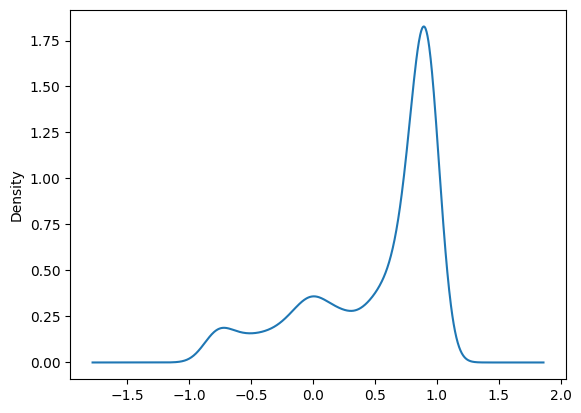

In [ ]:
cat_sentiment_scores.plot(kind='kde')

<Axes: ylabel='Frequency'>

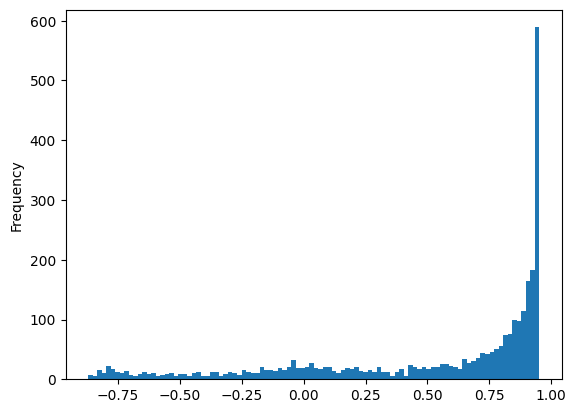

In [ ]:
cat_sentiment_scores.plot(kind='hist', bins=100)

In [ ]:
catalysts_filt['sentiment_score'] = cat_sentiment_scores

In [ ]:
catalysts_filt.to_csv("./drive/MyDrive/Colab Notebooks/catalyst_with_sentiment.csv", index=False)

In [ ]:
catalysts_filt['sentiment_score'].min()

-0.8707720637321472

In [ ]:
catalysts_filt['sentiment_score'].max()

0.9510200023651123